Next, a classifier was created using each neuron as a feature. The neurons relevant to this analysis were those that had average spike rates >.5hz and at least 10 error trials. The functions below use a support vector machine classifier to predict outcome (error or correct) based on spike count over the time windows. A bin size of 400ms was used with a step size of 20ms. Each bin was repeated for 50 iterations. The resulting plot shows an averaged accuracy over time per region.

In [1]:
# Install required packages
!pip install numpy scipy matplotlib scikit-learn

In [2]:
import numpy as np
import os
import scipy.io
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np

def process_data(directory_path, bin_size, step_size):
    # Define overlapping time bins using step size
    time_bins = np.arange(-500 * 1_000, 1501 * 1_000 - bin_size * 1_000, step_size * 1_000)
    all_neurons_data = {}

    for filename in os.listdir(directory_path):
        if filename.endswith('.mat'):
            file_path = os.path.join(directory_path, filename)
            print(f"Processing file: {file_path}")
            data = scipy.io.loadmat(file_path)

            # Extract data
            answers = data['answers']
            colors_presented = data['colorsPresented']
            events = data['events']
            button_press_times = events[:, 1]  # Button press times
            timestamps = data['timestampsOfCell']  # Spike timestamps

            # Determine outcomes
            outcomes = np.where(answers == colors_presented, 0, 1)  # 0 = correct, 1 = error

            # Initialize arrays for spike counts per trial and outcome
            correct_trials = []
            error_trials = []

            # Bin the spike counts for each trial
            for i, outcome in enumerate(outcomes):
                spike_counts = []

                for time_bin in time_bins:
                    # Define the current time bin's window
                    bin_start = button_press_times[i] + time_bin  # Start of bin
                    bin_end = bin_start + bin_size * 1_000  # End of bin

                    # Calculate the spike count for this time bin for the current trial
                    spike_count = np.sum((timestamps >= bin_start) & (timestamps < bin_end))
                    spike_counts.append(spike_count)

                # Group trials based on outcome
                if outcome == 0:
                    correct_trials.append(spike_counts)
                else:
                    error_trials.append(spike_counts)

            # Store the binned spike counts for this neuron
            all_neurons_data[filename.replace('.mat', '')] = {
                'correct': np.array(correct_trials),
                'error': np.array(error_trials)
            }

    return all_neurons_data


def svm(all_neurons_data, bin_size, step_size, iterations):
    time_bins = np.arange(-500, 1501 - bin_size, step_size)  # Time bins in ms
    accuracy_vs_time = []

    # Loop over each sliding bin
    for bin_idx in range(len(time_bins)):
        bin_accuracies = []

        for _ in range(iterations):
            feature_matrix = []
            labels = [0] * 10 + [1] * 10

            # Loop through all neurons and randomly select 10 correct and 10 error trials
            for neuron, spike_data in all_neurons_data.items():
                correct_trials = spike_data['correct'][:, bin_idx]  # Spike counts for this bin
                error_trials = spike_data['error'][:, bin_idx]  # Spike counts for this bin

                # Randomly sample 10 trials for each outcome
                sampled_correct = shuffle(correct_trials)[:10]
                sampled_error = shuffle(error_trials)[:10]

                # Combine the selected trials into a single list
                trials_for_neuron = np.concatenate([sampled_correct, sampled_error])

                # Append the trials for this neuron to the feature matrix
                feature_matrix.append(trials_for_neuron)

            # Convert feature matrix to numpy array and check shape
            feature_matrix = np.array(feature_matrix).T  # Shape (20, # neurons)
            labels = np.array(labels)  # Shape (20,)

            # Perform cross-validation on this feature matrix
            svm_model = SVC(kernel='linear')
            cv_scores = cross_val_score(svm_model, feature_matrix, labels, cv=5)
            bin_accuracies.append(np.mean(cv_scores))

        # Compute average accuracy for this sliding bin
        accuracy_vs_time.append(np.mean(bin_accuracies))

    return accuracy_vs_time


def plot_accuracy_vs_time(accuracy_vs_time, bin_size, step_size, label):
    # Define the time bins
    time_bins = np.arange(-500, 1501 - bin_size, step_size)  # Time bins in ms

    # Check if lengths match
    if len(accuracy_vs_time) != len(time_bins):
        raise ValueError("Length of accuracy_vs_time does not match the number of time bins!")

    # Plot the accuracy over time
    plt.figure(figsize=(10, 6))
    plt.plot(time_bins, accuracy_vs_time, marker='o', label='Accuracy')

    # Add labels, title, and grid
    plt.axhline(y=0.5, color='r', linestyle='--', label='Chance Level (50%)')
    plt.xlabel('Time (ms) relative to button press')
    plt.ylabel('Classification Accuracy')
    plt.title('Classifier Accuracy Over Time (Sliding Window): '+label)
    plt.grid(True)
    plt.legend()
    plt.savefig("outputs/"+label+"_accuracy_svm.png")



The model was then called on all AMY and HIP neurons that had at least 10 error trials and an average spike rate > .5hz.

Processing file: svm_neurons/amy/s75ch60ba3c2.mat
Processing file: svm_neurons/amy/s100ch52ba3c2.mat
Processing file: svm_neurons/amy/s130ch184ba3c2.mat
Processing file: svm_neurons/amy/s130ch183ba3c2.mat
Processing file: svm_neurons/amy/s131ch181ba3c2.mat
Processing file: svm_neurons/amy/s63ch33ba3c1.mat
Processing file: svm_neurons/amy/s101ch56ba3c3.mat
Processing file: svm_neurons/amy/s29ch31ba4c3.mat
Processing file: svm_neurons/amy/s102ch49ba3c1.mat
Processing file: svm_neurons/amy/s66ch11ba4c1.mat
Processing file: svm_neurons/amy/s2ch50ba4c1.mat
Processing file: svm_neurons/amy/s91ch56ba3c2.mat
Processing file: svm_neurons/amy/s85ch53ba3c1.mat
Processing file: svm_neurons/amy/s2ch51ba4c1.mat
Processing file: svm_neurons/amy/s103ch55ba3c1.mat
Processing file: svm_neurons/amy/s2ch55ba4c1.mat
Processing file: svm_neurons/amy/s91ch50ba3c1.mat
Processing file: svm_neurons/amy/s91ch56ba3c1.mat
Processing file: svm_neurons/amy/s29ch32ba4c2.mat
Processing file: svm_neurons/amy/s131ch150b

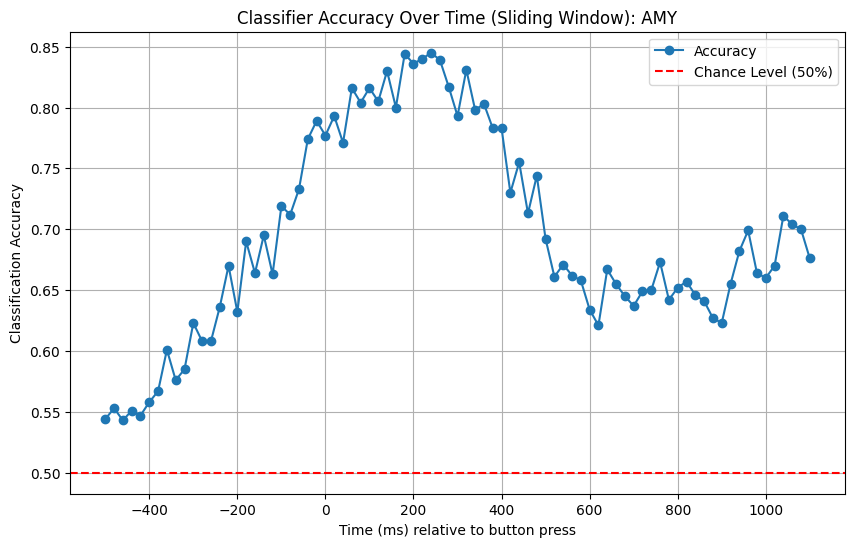

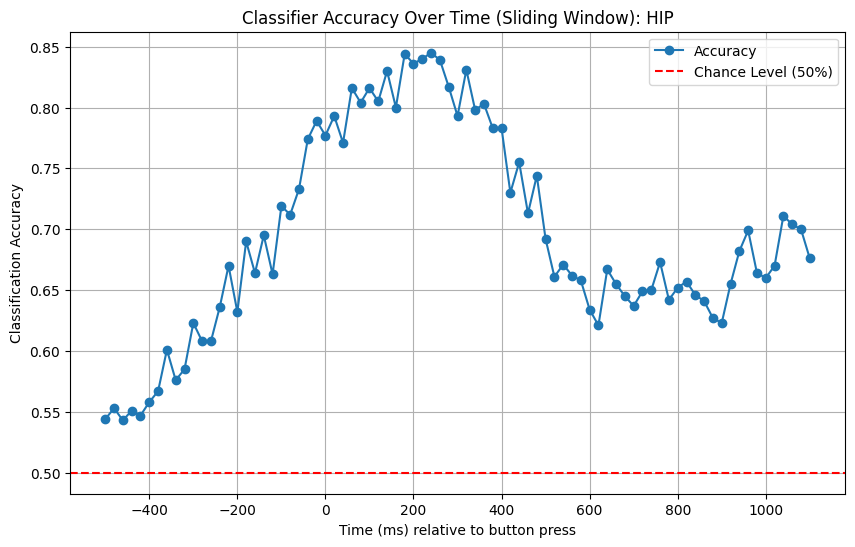

In [4]:
# Calling SVM
##############################################################################
bin_size = 400  # ms bins
step_size = 20  # ms steps
iterations = 50  # Number of iterations for averaging

directory_path_amy = "svm_neurons/amy"
directory_path_hip = "svm_neurons/hip"

# Process the data
all_neurons_data_amy = process_data(directory_path_amy, bin_size, step_size)
all_neurons_data_hip = process_data(directory_path_hip, bin_size, step_size)

# Run SVM analysis
accuracy_vs_time_amy = svm(all_neurons_data_amy, bin_size, step_size, iterations)
accuracy_vs_time_hip = svm(all_neurons_data_hip, bin_size, step_size, iterations)

# Output the accuracy vs time
print("Accuracy vs time for AMY:", accuracy_vs_time_amy)
print("Accuracy vs time for HIP:", accuracy_vs_time_hip)

plot_accuracy_vs_time(accuracy_vs_time_amy, bin_size, step_size, label="AMY")
plot_accuracy_vs_time(accuracy_vs_time_amy, bin_size, step_size, label="HIP")
